In [1]:
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv('./datasets/challenge_train.csv')
validation_df = pd.read_csv('./datasets/challenge_test.csv')

In [3]:
print(train_df.shape)
print(validation_df.shape)

(788, 8)
(198, 7)


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788 entries, 0 to 787
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        788 non-null    int64 
 1   name      788 non-null    object
 2   mana      788 non-null    int64 
 3   attack    788 non-null    int64 
 4   health    788 non-null    int64 
 5   type      788 non-null    object
 6   god       788 non-null    object
 7   strategy  788 non-null    object
dtypes: int64(4), object(4)
memory usage: 49.4+ KB


In [5]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      198 non-null    int64 
 1   name    198 non-null    object
 2   mana    198 non-null    int64 
 3   attack  198 non-null    int64 
 4   health  198 non-null    int64 
 5   type    198 non-null    object
 6   god     198 non-null    object
dtypes: int64(4), object(3)
memory usage: 11.0+ KB


In [6]:
# Game mana increase 1 by turn until 6, after that is slower
train_df['mana_group'] = pd.cut(train_df['mana'], 5, labels=[0,1,2,3,4])
train_df['attack_group'] = pd.cut(train_df['attack'], 5, labels=[0,1,2,3,4])
train_df['health_group'] = pd.cut(train_df['attack'], 5, labels=[0,1,2,3,4])
gods_c = {'neutral': 0,
          'light': 1,
          'nature': 2,
          'deception': 3,
          'death': 4,
          'war': 5,
          'magic': 6}
train_df['god_categories'] = train_df['god'].map(lambda x: gods_c.get(x, 7))
type_c = {'creature': 0,
          'spell': 1,
          'weapon': 2,
          'god power': 3}
train_df['type_categories'] = train_df['type'].map(lambda x: type_c.get(x, 4))
train_df['strategy_categories'] = train_df['strategy'].map(lambda x: 0 if x == 'early' else 1)

In [7]:
import seaborn as sns
%matplotlib inline

sns.set_style("white")
sns.set_palette('crest')

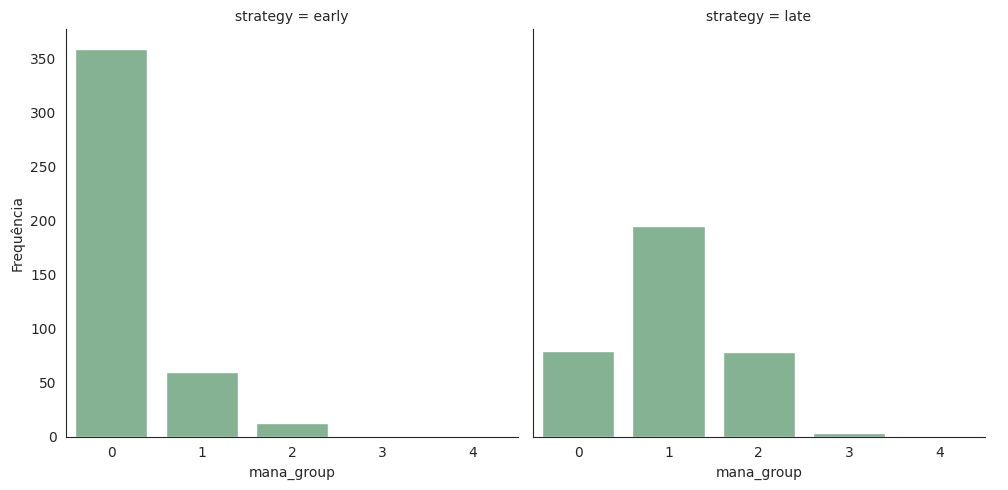

In [8]:
## The group_code 0 correspont to the majority of the customers and also the majority of the `is_churn`
graf_gen = sns.catplot(x = 'mana_group', col = 'strategy', kind = 'count', data = train_df);
graf_gen.set(ylabel = 'Frequência');

<Axes: xlabel='mana', ylabel='health'>

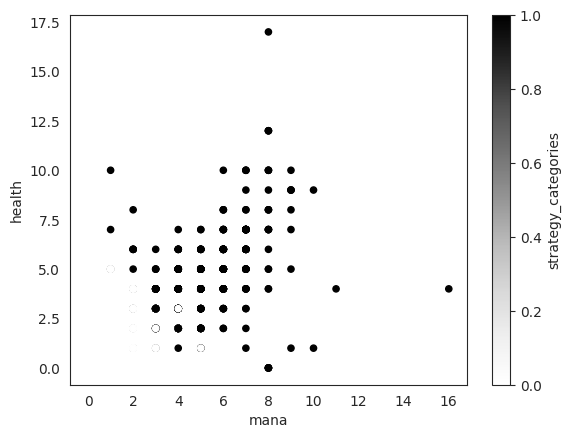

In [9]:
train_df.plot.scatter(x='mana', y='health', c='strategy_categories')

In [10]:
train_df['attack'].value_counts()

attack
0     251
2     134
1     113
3     111
4      68
5      43
6      36
7      13
8       7
10      5
9       4
12      2
13      1
Name: count, dtype: int64

In [32]:
(vb, mb) = pd.cut(train_df['mana'], 5, retbins=True)
(_, ab) = pd.cut(train_df['attack'], 5, retbins=True)
(_, hb) = pd.cut(train_df['health'], 5, retbins=True)

In [33]:
vb.value_counts()

mana
(-0.016, 3.2]    438
(3.2, 6.4]       255
(6.4, 9.6]        91
(9.6, 12.8]        3
(12.8, 16.0]       1
Name: count, dtype: int64

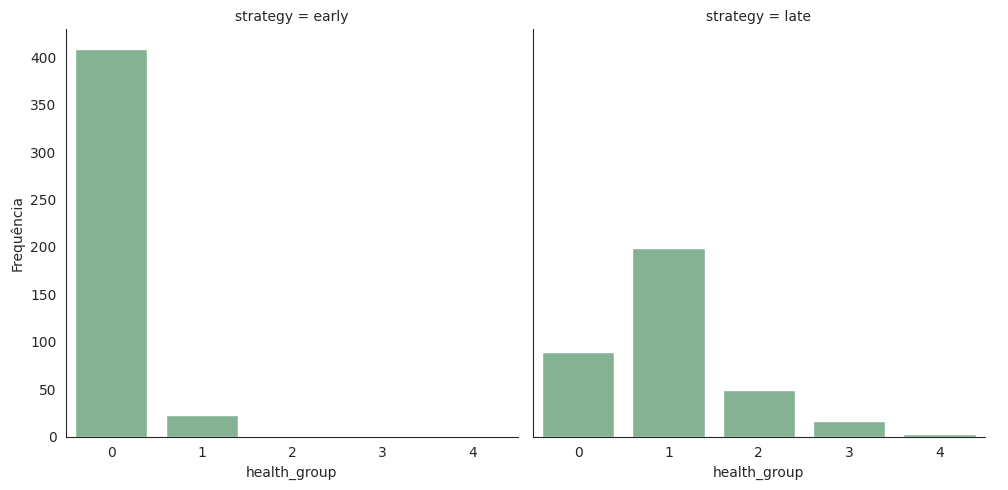

In [13]:
graf_gen = sns.catplot(x = 'health_group', col = 'strategy', kind = 'count', data = train_df);
graf_gen.set(ylabel = 'Frequência');

In [14]:
train_df.columns

Index(['id', 'name', 'mana', 'attack', 'health', 'type', 'god', 'strategy',
       'mana_group', 'attack_group', 'health_group', 'god_categories',
       'type_categories', 'strategy_categories'],
      dtype='object')

### Model

In [15]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

X = train_df[['type_categories', 'god_categories', 'mana_group', 'attack_group', 'health_group', 'mana', 'health', 'attack']]
y = train_df['strategy_categories']

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X[['type_categories', 'god_categories', 'mana_group', 'attack_group', 'health_group']], 
    y, test_size=0.2, random_state=42)

In [17]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['type_categories', 'god_categories', 'mana_group', 'health_group', 'attack_group'])
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

In [18]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 11,
    'learning_rate': 0.05,
}


In [19]:
num_round = 100
lgb_model = lgb.train(params, train_data, num_round,
                valid_sets=[train_data, valid_data])


[LightGBM] [Info] Number of positive: 290, number of negative: 340
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 630, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.460317 -> initscore=-0.159065
[LightGBM] [Info] Start training from score -0.159065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [66]:
y_pred = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
y_pred_binary = (y_pred > 0.5).astype(int)
 
accuracy = accuracy_score(y_valid, y_pred_binary)
print(f"Validation Accuracy: {accuracy:.2f}")

r = X_valid.iloc[0].to_dict()
print(r, y_valid.iloc[0])
p = lgb_model.predict(np.asarray(list(r.values())).reshape(1, -1), num_iteration=lgb_model.best_iteration)
print(p, type(p))
print((p > 0.5).astype(int)[0])

Validation Accuracy: 0.95
{'type_categories': 1, 'god_categories': 4, 'mana_group': 0, 'attack_group': 0, 'health_group': 0} 0
[0.0314585] <class 'numpy.ndarray'>
0


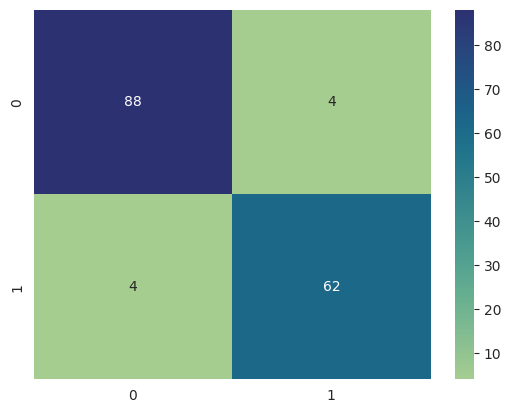

In [21]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_valid, y_pred_binary)
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = "crest", fmt = 'g');

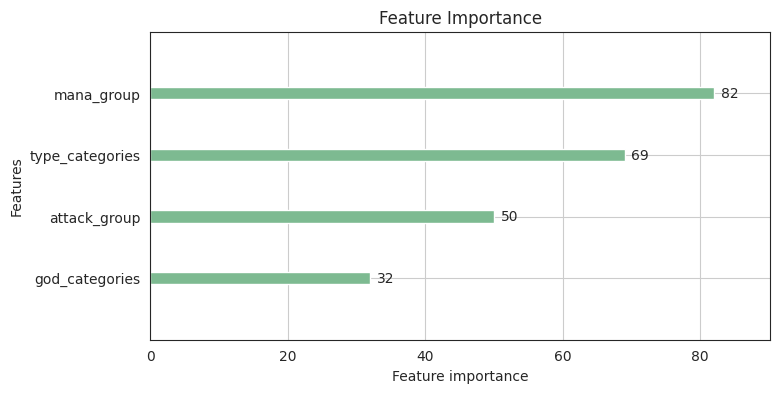

In [22]:
lgb.plot_importance(lgb_model, figsize=(8, 4))
plt.title("Feature Importance")
plt.show()

In [24]:
import joblib

In [25]:
joblib.dump(lgb_model, "lgb_model.joblib")

['lgb_model.joblib']